# Revisiting Food-Safety Inspections from the Chicago Dataset - A Tutorial (Part 1)
## 1. Introduction
Foodborne illnesses afflict 48 million Americans each year, resulting in 128,000 hospitalizations and 3,000 deaths [(CDC)](https://www.cdc.gov/foodborneburden/index.html). City governments curb the spread of illness by enforcing stringent health codes but often face daunting inspection schedules and severe budget constraints. To meet regulations both public officials and the businesses they inspect must make difficult decisions in allocating scarce resources.

In this tutorial we present our efforts to support these decision-makers by predicting when and where health code violations will occur. As we draw from past research, clean and explore available datasets and ultimately build and test a predictive model of inspection outcomes we invite you to share any questions, comments or critiques that come to mind. This project would not be possible without generous community support and we welcome the opportunity to extend that community and expand our skills as developers and data scientists.

### 1.1. Past Work
In the city of Chicago health code violations are rated as minor, serious or critical. Critical violations denote a pressing hazard to public health and an automatic failed inspection, so a health inspector's job is essentially to minimize the duration for which critical violations go undiscovered.

In 2014 the Chicago Department of Public Health (CDPH) began work on a [predictive model of inspection outcomes](https://chicago.github.io/food-inspections-evaluation/) to facilitate the discovery of critical violations. The team explored a number of datasets and features before eventually arriving at the following list of predictors:
* inspector assigned
* previous inspection outcomes
* age at inspection
* license for alcohol consumption on premises
* license for over counter tobacco retail
* local temperature at time of inspection
* nearby burglaries
* nearby sanitation complaints
* nearby garbage cart requests.

Using a glmnet model trained on these features the team was able to demonstrate that a data-driven inspections schedule could significantly reduce the time to find a critical violation. This improved inspections schedule has since been adopted by the CDPH and both the [model](https://github.com/Chicago/food-inspections-evaluation) and [data used](https://data.cityofchicago.org/) have been made publicly available.

### 1.2. Premise
In light of the CDPH's success we began this project as an exploration and extension of their work. Whereas the Chicago team set out to predict critical violations, we are working to develop a series of models predicting individual violations as well as to explore neural networks for the prediction model.

By developing a higher resolution model we hope to provide actionable information not just to public officials but to restaurants themselves. In addition to a general interest in customers' health restaurants are fined \$500 for each critical and $250 for each serious violation found, and so are strongly motivated to maintain health codes. A real-time violation risk analysis could thus provide actionable information to restaurants on an ongoing basis, improving inspection outcomes and promoting public health.

### 1.3. Data
Although we are developing a more specific model than the CDPH and using different tools to do our investigative question is similar. Thus we began by preparing those datasets and features that the Chicago team found to be significant. While we may draw from additional datasets as work progresses the current list is as follows:
* [food inspections](https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5/data)
* [business licenses](https://data.cityofchicago.org/Community-Economic-Development/Business-Licenses/r5kz-chrr/data)
* [garbage cart requests](https://www.cityofchicago.org/city/en/dataset/garbage_cart_stolenormissing.html)
* [sanitation code complaints](https://data.cityofchicago.org/Service-Requests/311-Service-Requests-Sanitation-Code-Complaints/me59-5fac/data)
* [crimes](https://data.cityofchicago.org/Public-Safety/Crimes-2018/3i3m-jwuy/data)
* [weather](https://darksky.net/dev)

With the exception of weather data from darksky.net all data used is available through the [Chicago Data Portal](https://data.cityofchicago.org/). We will not be working with data on inspector assigned as this is not publicly available and so not useful in practice.

## 2. Pre-processing and Data Structuring
In order to derive insights from our data we first had to ensure that each dataset is consistent and ready for further processing (e.g. standardizing column names, removing duplicates, filtering unwanted data, converting types). After this preliminary cleaning we then had to translate certain observations into a form more convenient for analysis (e.g. splitting strings of violations into a series of binary violation columns). Finally we used this data to derive secondary features like the critical violation count or the time since last inspection. The results of these processes are [available on dropbox].

### 2.1. Preparation of Food Inspections Data

To download the inspections data we used Sodapy, a client for the Socrata Open Data API (the data platform used by the Chicago Data Portal):

In [1]:
%%capture
!pip install sodapy

In [2]:
import pandas as pd
import numpy as np
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofchicago.org", None)

Conveniently,  Sodapy converts all columns to snake case, removes special characters and standardizes date format by default:

In [3]:
# First 50000 results, returned as JSON from API 
# Connverted to Python list of dictionaries by sodapy.
# Column names converted to snake case, special chars removed
# Dates and location formatted
results = client.get("4ijn-s7e5", limit=50000)

# Convert to pandas DataFrame
inspections = pd.DataFrame.from_records(results)

As Socrata restricts queries to 50000 entries we then paged through the remainder to access the full dataset: 

In [4]:
# Download remaining food inspections (limit 50000 / call)
start = 50000
while results:
    results = client.get("4ijn-s7e5", limit=50000, offset=start)
    inspections = inspections.append(pd.DataFrame.from_records(results))
    start += 50000

After exploring the data and reading through the CDPH's work in R we then applied a series of filters to produce a consistent and usable dataset:

In [5]:
# Remove trailing backslash (left over from sodapy conversion of "License #" column)
inspections.rename(columns={"license_": "license"}, inplace=True)

# Drop rows with missing data
inspections.dropna(subset=["inspection_date", "license", "latitude", "longitude"], inplace=True)

# Convert latitude and longitude to float
inspections.latitude = inspections.latitude.astype(float)
inspections.longitude = inspections.longitude.astype(float)

# Drop duplicates
inspections.drop_duplicates("inspection_id", inplace=True)

# Drop "0" licenses
inspections = inspections[inspections.license != "0"]

# Only consider successful inspections
inspections = inspections[~inspections.results.isin(["Out of Business", "Business Not Located", "No Entry"])]

For later calculations we converted location data to floats:

In [6]:
# Convert latitude & longitude to floats
inspections.latitude = inspections.latitude.astype(float)
inspections.longitude = inspections.longitude.astype(float)

In addition to semi-regular canvas inspections facilities may also be inspected due to complaints or a recent failed inspection. To ensure that our data is representative of restaurants operating as usual we filtered the dataset to consist only of canvas inspections:

In [7]:
# Only consider canvas inspections (not complaints or re-inspections)
inspections = inspections[inspections.inspection_type == "Canvass"]

We also filtered inspections by facility type, to eliminate the inconsistency of data from sources like hospitals or schools which follow different inspection schedules:

In [8]:
# Only consider restaurants and grocery stores (subject to change)
inspections = inspections[inspections.facility_type.isin(["Restaurant", "Grocery Store"])]

Finally we saved the resulting dataframe as a CSV file, ready for later use:

In [9]:
import os.path
root_path = os.path.dirname(os.getcwd())

# Save result
inspections.to_csv(os.path.join(root_path, "DATA/food_inspections_demo.csv"), index=False)

### 2.2. Preparation of Remaining Socrata Data
The process of downloading and filtering business licenses, garbage cart requests, sanitation complaints and crimes was much the same as with food inspections - for specifics please see the [CODE folder of our project repository](https://github.com/Sustainabilist/ChicagoDataAnalysis/tree/master/CODE). 

In brief:
* All datasets were formatted by sodapy and filtered to remove duplicates and missing data.
* Crimes were filtered to include only burglaries since 2010 to reduce size and ensure consistency.
* Garbage cart requests and sanitation complaints were filtered to include only completed or open requests.

### 2.3. Preparation of Weather Data
The process of pulling the weather data from the [Darksky API](https://darksky.net/dev) was straightforward and can be found in notebook 16 in the CODE folder of our project repository. To eliminate redundant API calls, the script first imports any existing weather data and checks this data first before each request.

Each weather record consists of an inspection ID, a date, the pricipitation intensity, the maxiumum temperature, the windspeed and the humidity at that date. As the inspections region only measures some twenty miles across we used a single location in central Chicago for all weather records.

### 2.4. Calculation of Violations Data
Each entry in the violations column of the food inspections dataset is made up of a number of violation/comment pairs joined into a string:

In [10]:
inspections.iloc[2].violations

'33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS - Comments: OBSERVED THE CUTTING BOARDS IN THE PREP AREA NOT CLEAN, INSTRUCTED TO CLEAN AND SANITIZE. ALSO THE LARGE BOX FREEZER NOT CLEAN, IN SIDE STORAGE, AND THE 2 DOOR FREEZER IN REAR PREP NOT CLEAN. INSTRUCTED TO CLEAN.  | 35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS - Comments: OBSERVED DUSTY CEILING VENT IN FRONT OF THE LADIES RESTROOM, INSTRUCTED TO CLEAN, ALSO CLEAN LIGHT SHIELD IN 1ST. LADIES RESTROOM, AND CLEAN THE WALL IN COOKING AREA. | 39. LINEN: CLEAN AND SOILED PROPERLY STORED - Comments: OBSERVED THE WIPING CLOTHES IMPROPERLY STORED  ON THE PREP TABLES IN THE REAR PREP AREA, INSTRUCTED TO STORE IN CLEAN CONTAINER OF SANITIZER.'

Although this represents a rich source of data, this format makes it difficult to perform operations based on specific violations (e.g. charting the distribution of critical violations).

To make violations data more accessible for analysis we split each entry into a series of columns representing the presence of each violation with binary flags:

In [12]:
# Split violations into binary values for each violation
def split_violations(violations):
    values_row = pd.Series([])
    if type(violations) == str:
        violations = violations.split(' | ')
        for violation in violations:
            index = "v_" + violation.split('.')[0]
            values_row[index] = 1
    return values_row

# 5 mins
values_data = inspections.violations.apply(split_violations)

We then generated a series of column titles of the form "v_1" for violations 1-14 (critical), 15-29 (serious) and 30-44 plus 70 (minor):

In [13]:
# Generate column names
critical_columns = [("v_" + str(num)) for num in range(1, 15)]
serious_columns = [("v_" + str(num)) for num in range(15, 30)]
minor_columns = [("v_" + str(num)) for num in range(30, 45)]
minor_columns.append("v_70")

columns = critical_columns + serious_columns + minor_columns

These column headings were then combined with the violation values and paired with the inspection id for each row:

In [14]:
# Ensure no missing columns, fill NaN
values = pd.DataFrame(values_data, columns=columns).fillna(0)

values['inspection_id'] = inspections.inspection_id

The resulting datatable is shown below:

In [15]:
values.head()

,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,...,v_37,v_38,v_39,v_40,v_41,v_42,v_43,v_44,v_70,inspection_id
39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2182015
49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2181991
65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2181967
68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2181959
70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2181953


While not especially human-readable, this format allows us to easily access specific violation data, sum sets of violations and generate models that require numeric or binary features.

Next we created a separate dataframe for critical, serious and minor violation counts by pairing each inspection id with the sum of the appropriate subset of violation values:

In [16]:
# Count violations
counts = pd.DataFrame({
    "critical_count": values[critical_columns].sum(axis=1),
    "serious_count": values[serious_columns].sum(axis=1),
    "minor_count": values[minor_columns].sum(axis=1)
})

counts['inspection_id'] = inspections.inspection_id

Lastly we saved both datasets for later use:

In [17]:
# Save violation values and counts
values.to_csv(os.path.join(root_path, "DATA/violation_values_demo.csv"), index=False)
counts.to_csv(os.path.join(root_path, "DATA/violation_counts_demo.csv"), index=False)

## 3. Exploratory Analysis
To familiarize ourselves with the data and to inform feature selection and model design we then took some time to explore and visualize. During this period we investigated the spatial distribution of inspections, the comments accompanying violations, the relative distribution of violations and the role of past inspection outcomes as predictors. We also looked at facility inspection statistics to assess the economic potential of violation forecasting.

### 3.1. Inspections Map
To improve our understanading of the inspections dataset and its relation to other location-based data we used seaborn and folium to generate an inspections heat map:

In [18]:
%%capture
!pip install folium

In [19]:
# Import necessary packages 
import folium
from folium import plugins
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [21]:
# Generate map
m = folium.Map([41.8600, -87.6298], zoom_start=10)

# Convert to (n, 2) nd-array format for heatmap
inspections_arr = inspections.sample(20000)[["latitude", "longitude"]].values

# Plot heatmap
m.add_child(plugins.HeatMap(inspections_arr.tolist(), radius=10))

### 3.2. Comments Wordcloud
Wordclouds are an easy and surprisingly insightful means to explore text data, so to explore the feedback that facilities recieve alongside violations we concatenated all comments and used the resulting string to generate a wordcloud:

In [22]:
%%capture
!pip install wordcloud

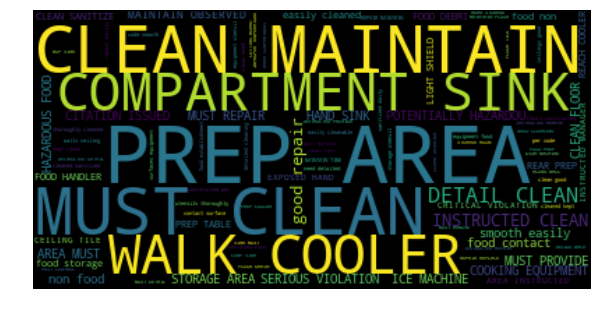

In [24]:
from wordcloud import WordCloud

# Extract comments from violations
def get_comments(violations):
    comments = ""
    if type(violations) == str:
        violations = violations.split(' | ')
        for violation in violations:
            violation = violation.split('Comments:')
            if len(violation) == 2:
                comments += violation[1]
    return comments

# Concatenate all comments
comments = inspections.violations.apply(get_comments).str.cat(sep=" ")

# Generate wordcloud
comments_wordcloud = WordCloud().generate(comments)

# Plot wordcloud
plt.rcParams['figure.figsize'] = (10, 10)
plt.imshow(comments_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Although qualitative the results point to maintenance, cleanliness, prep areas, sinks and coolers as common areas of concern.

### 3.4. Violations Chart
For a more quantitative perspective we used the violations data and [a chart of the Chicago health code](https://webapps1.cityofchicago.org/healthinspection/Code_Violations.jsp) to generate a simple bar graph:

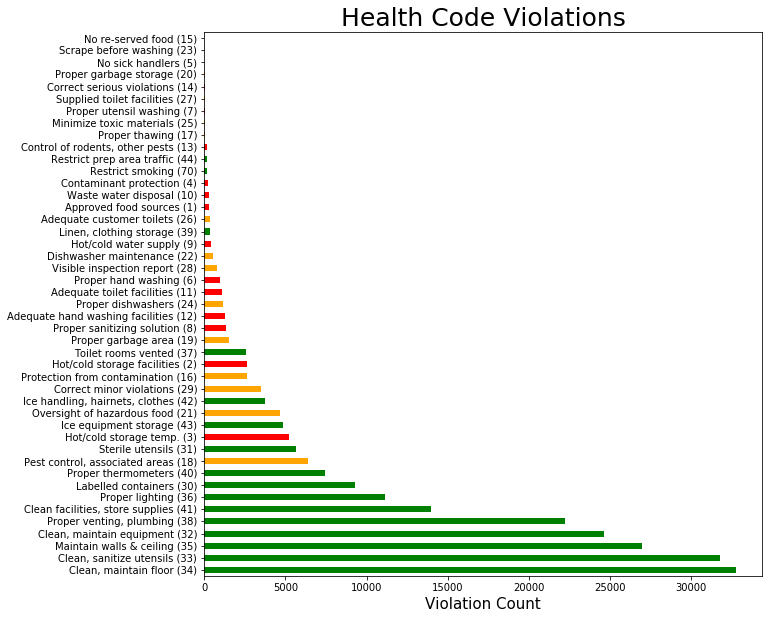

In [25]:
# List violation descriptions
descriptions = {"v_1": "Approved food sources (1)", "v_2": "Hot/cold storage facilities (2)", "v_3": "Hot/cold storage temp. (3)", "v_4": "Contaminant protection (4)", "v_5": "No sick handlers (5)", "v_6": "Proper hand washing (6)", "v_7": "Proper utensil washing (7)", "v_8": "Proper sanitizing solution (8)", "v_9": "Hot/cold water supply (9)", "v_10": "Waste water disposal (10)", "v_11": "Adequate toilet facilities (11)", "v_12": "Adequate hand washing facilities (12)", "v_13": "Control of rodents, other pests (13)", "v_14": "Correct serious violations (14)", "v_15": "No re-served food (15)", "v_16": "Protection from contamination (16)", "v_17": "Proper thawing (17)", "v_18": "Pest control, associated areas (18)", "v_19": "Proper garbage area (19)", "v_20": "Proper garbage storage (20)", "v_21": "Oversight of hazardous food (21)", "v_22": "Dishwasher maintenance (22)", "v_23": "Scrape before washing (23)", "v_24": "Proper dishwashers (24)", "v_25": "Minimize toxic materials (25)", "v_26": "Adequate customer toilets (26)", "v_27": "Supplied toilet facilities (27)", "v_28": "Visible inspection report (28)", "v_29": "Correct minor violations (29)", "v_30": "Labelled containers (30)", "v_31": "Sterile utensils (31)", "v_32": "Clean, maintain equipment (32)", "v_33": "Clean, sanitize utensils (33)", "v_34": "Clean, maintain floor (34)", "v_35": "Maintain walls & ceiling (35)", "v_36": "Proper lighting (36)", "v_37": "Toilet rooms vented (37)", "v_38": "Proper venting, plumbing (38)", "v_39": "Linen, clothing storage (39)", "v_40": "Proper thermometers (40)", "v_41": "Clean facilities, store supplies (41)", "v_42": "Ice handling, hairnets, clothes (42)", "v_43": "Ice equipment storage (43)", "v_44": "Restrict prep area traffic (44)", "v_70": "Restrict smoking (70)"}

# Rename with descriptions, sum binary values for each violation
sums = values.drop(columns=["inspection_id"]).rename(columns=descriptions).sum()

# Generate color list
colors = ["red"] * 15 + ["orange"] * 14 + ["green"] * 16

# Sort sums and colors by sum value
sum_data = pd.DataFrame({"sums": sums, "colors": colors}).sort_values("sums")

# Plot bar chart
plt.rcParams['figure.figsize'] = (10, 10)
ax = sum_data.sums.plot(kind="barh", color=sum_data.colors)
ax.set_title("Health Code Violations", fontsize=25)
ax.set_xlabel("Violation Count", fontsize=15)
ax.invert_yaxis()
plt.show()

As this chart makes clear, the vast majority of violations are minor (v_30+), with only a scattering of serious (v_15-29) and critical (v_1-14) violations.

The most common violations pertain to cleanliness and maintenance of floors, walls and ceilings; sanitation and maintenance of utensils and equipment; proper venting; and proper organization of food and cleaning supplies.

The most common serious violation is improper control of vermin (v_18), and the most common critical violations relate to improper storage of hot and cold foods (v_2, v_3).

### 3.5. Inspection History
The Chicago team found one of the greatest predictors of critical violations and failed inspections to be the establishment's recent inspection history. To investigate this we grouped inspections by license, shifted each group to find the previous inspection and set up a table to compare conditional likelihoods:

In [26]:
# Sort inspections by date
inspections.sort_values(by="inspection_date", inplace=True)

# Group inspections by license and shift 1 to find previous results
inspections["previous_results"] = inspections.groupby(by="license").shift().results

# Calculate cross tabulation of results and previous results
pd.crosstab(inspections.previous_results, inspections.results)

results,Fail,Not Ready,Pass,Pass w/ Conditions
previous_results,,,,
Fail,2426,1,4299,1425
Not Ready,2,1,11,0
Pass,4818,13,18914,3523
Pass w/ Conditions,1612,3,3322,1360


In [27]:
# P(fail | fail)
2416 / len(inspections[inspections["previous_results"] == "Fail"])

0.296405349036928

In [28]:
# P(fail | pass)
4800 / len(inspections[inspections["previous_results"] == "Pass"])

0.17603051195540562

We found that facilities with a previous failure were almost twice as likely to fail as those with previous passing inspections, supporting the findings of the Chicago team.

### 3.6. Economic Impact
Before investing time in a violations forecasting tool for businesses we first set out to assess whether such information would actually be valuable. If businesses rarely fail inspections and generally do so in summer, for example, even perfect information would not provide much additional value.

To explore this we first formed a temporary dataframe with the relevant data:

In [98]:
# Create temporary dataframe
temp = pd.merge(inspections, values, on="inspection_id")

# Convert inspection_date to datetime format
temp["datetime"] = pd.to_datetime(temp["inspection_date"])

# Calculate fines
temp["fines"] = temp[critical_columns].sum(axis=1) * 500
temp["fines"] += temp[serious_columns].sum(axis=1) * 250

We then grouped inspections by license (a code shared by all inspections for a business) and for each group determined the age, yearly fails and several other statistics:

In [102]:
import math

# Sort by date
temp.sort_values("datetime", inplace=True)

# Calculate statistics for license groups
def get_stats(group):
    days = (group.iloc[-1].datetime - group.iloc[0].datetime).days + 1
    years = days / 365.25  
    inspections = len(group)
    yearly_inspections = inspections / math.ceil(years)
    fails = len(group[group.results == "Fail"])
    yearly_fails = fails / math.ceil(years)
    fines = group.fines.sum()
    yearly_fines = fines / math.ceil(years)
    return pd.Series({
        "years": years,
        "inspections": inspections,
        "yearly_inspections": yearly_inspections,
        "fails": fails,
        "yearly_fails": yearly_fails,
        "fines": fines,
        "yearly_fines": yearly_fines
    })

# Group by license and apply get_stats
businesses = temp.groupby('license').apply(get_stats).reset_index()

To explore whether businesses fail enough inspections for risk analysis to be worthwhile we plotted the businesses in each yearly fails bracket:

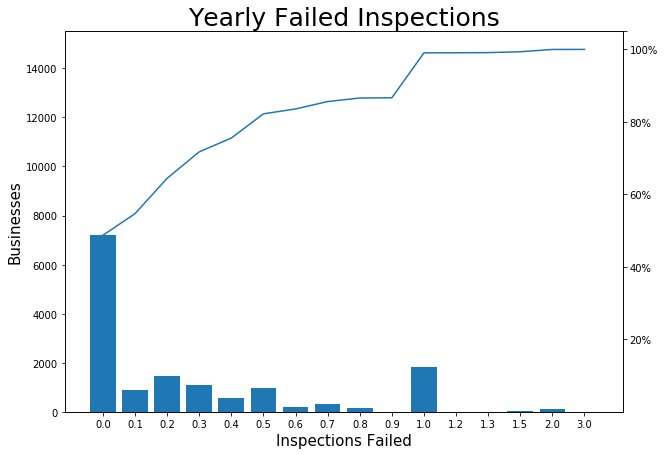

In [168]:
# Calculate fails per rounded year
yearly_fails = licenses.fails / np.ceil(licenses.years)

# Count restaurants in each rounded yearly fails bracket
yearly_fail_counts = yearly_fails.round(1).value_counts().sort_index()

index = np.arange(len(yearly_fail_counts))

plt.rcParams['figure.figsize'] = (10, 7)

fig, ax1 = plt.subplots()
ax1.bar(index, yearly_fail_counts)
ax1.plot(index, yearly_fail_counts.cumsum())
ax1.set_xticks(index)
ax1.set_xticklabels(yearly_fail_counts.index)
ax1.set_title("Yearly Failed Inspections", fontsize=25)
ax1.set_xlabel("Inspections Failed", fontsize=15)
ax1.set_ylabel("Businesses", fontsize=15)

ax2 = ax1.twinx()
ax2.set_yticks([1, 2, 3, 4, 5, 5.25])
ax2.set_yticklabels(["%d%%"%(x*20) for x in range(1,6)])

plt.show()

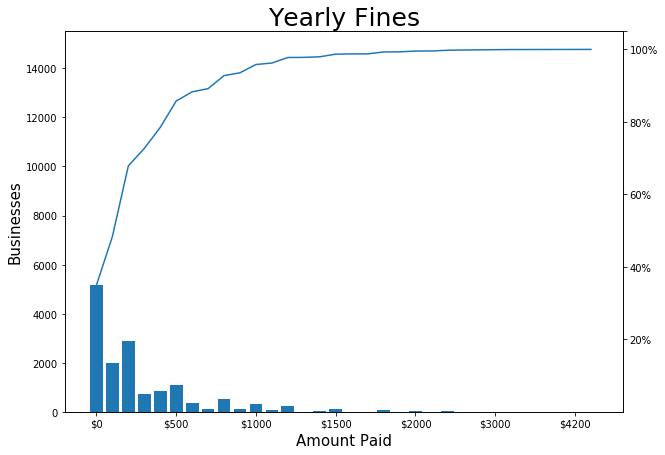

In [169]:
# Count restaurants in each rounded yearly fails bracket
fine_counts = businesses.yearly_fines.round(-2).value_counts().sort_index()

index = np.arange(len(fine_counts))


fig, ax1 = plt.subplots()
ax1.bar(index, fine_counts)
ax1.plot(index, fine_counts.cumsum())
ax1.set_xticks(index[::5])
ax1.set_xticklabels(["$%d"%x for x in fine_counts.index[::5]])
ax1.set_title("Yearly Fines", fontsize=25)
ax1.set_xlabel("Amount Paid", fontsize=15)
ax1.set_ylabel("Businesses", fontsize=15)

ax2 = ax1.twinx()
ax2.set_yticks([1, 2, 3, 4, 5, 5.25])
ax2.set_yticklabels(["%d%%"%(x*20) for x in range(1,6)])

plt.show()

We found that after a huge number of facilities with a 100% pass rate there is a gradual die-off in yearly fails, with some 2,000 out of 15,000 businesses failing one or more yearly inspections. 

Finally we computed a cross-tabulation of failure rate and business age to explore performance and survival over time:

In [170]:
print(len(businesses), len(inspections.license.value_counts()))

14772 14772


In [171]:
# Select yearly fails series
yearly_fails = businesses.yearly_fails

# Count businesses and businesses failing 1 or more inspections yearly
print(len(businesses), len(yearly_fails[yearly_fails >= 1]))

14772 1972


The results suggest a high failure rate and die-off rate for businesses early on, transitioning to a lower failure rate and die-off rate for more established businesses. Early inspection failures could by a cause of closure, a symptom of adverse conditions or both.

In summary we do believe that there is sufficient opportunity for a risk analysis tool to justify development. A failed inspection costs a business at minimum $500 in fines and represents a serious risk to public health. For new and potentially struggling businesses especially an advanced assessment of health and inspection risks could prove highly valuable.

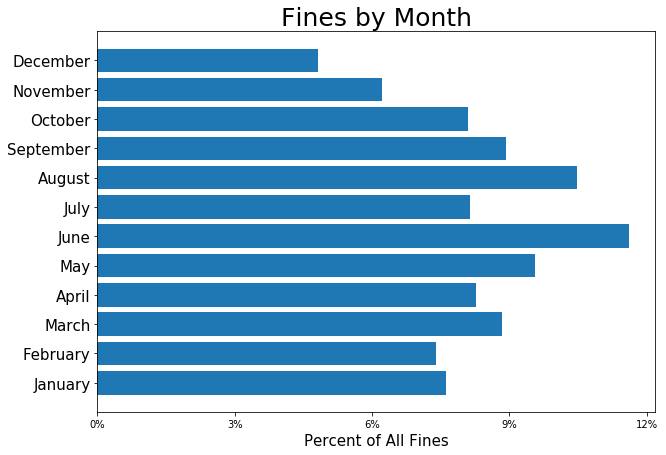

In [199]:
# Calculate total fines paid for each month
temp["month"] = temp.datetime.apply(lambda x: x.month)
month_fines = temp.groupby("month").fines.sum() / temp.fines.sum()

# List months
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

# Plot bar chart
fig, ax = plt.subplots()
index = np.arange(len(month_fines))
ax.barh(index, month_fines)
ax.set_yticks(index)
ax.set_yticklabels(months, fontsize=15)
ax.set_xticks([x*3/100 for x in range(5)])
ax.set_xticklabels(["%d%%"%(x*3) for x in range(5)])
ax.set_title("Fines by Month", fontsize=25)
ax.set_xlabel("Percent of All Fines", fontsize=15)


plt.show()

## 5. Next Steps
[UNDECIDED]
* Kernel density estimation
* Selection of features
* Calculation of model data
* Process engineering? Control charts?
* neural net for critical violations
* compare results to CDPH's model
* neural net for individual violations
* look at which things can actually be predicted and would provide actionable info
* develop forecast tool
* disseminate forecast tool

## About the Authors (consider putting up top)
[NEEDS SOMETHING ABOUT JASON/SUSTAINABILIST?]
* David Lewis is a seasoned corporate responsibility professional working to utilize technology to help improve the health and well being of human populations through environmental stewardship. 
* Russell Hofvendahl is a web application developer with a deep-seated love of data driven decision making.

##  Technologies Used (not crazy about this section, and should maybe go up top)
We performed initial exploration with Python 3.6 notebooks running on the cloud-based [Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb) Jupyter environment; for later work we used local Jupyter notebooks shared through [our Github repository](https://github.com/Sustainabilist/ChicagoDataAnalysis), with dropbox for large file sharing. We used pip 9 for packages and pandas for data manipulation. We communicated and coordinated work through slack, trello and notable.